In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init
from torch.autograd import grad

from utils import FeedForwardNetwork, plot_pde, plot_losses, rmse

In [2]:
class Diffusion:
    def __init__(self, D, boundaries, resolution, b_values):
        self.D = D
        self.L, self.R, self.T = boundaries
        self.left_boundary, self.right_boundary, self.initial_values = b_values
        
        self.Nt, self.Nx = resolution
        self.solution = self._solve()
        self.t = torch.linspace(0, self.T, self.Nt)
        self.x = torch.linspace(self.L, self.R, self.Nx)
        
        self.left_values, self.right_values, self.init_values = None, None, None
    
    def loss_boundary(self, model, t_left, t_right, x_init):
        left =  model(torch.vstack([torch.ones_like(t_left)  * self.L, t_left]).T)
        right = model(torch.vstack([torch.ones_like(t_right) * self.R, t_right]).T)
        init =  model(torch.vstack([x_init, torch.zeros_like(x_init)]).T)
        
        left_error = torch.square(self.left_values - left.flatten()).mean()
        right_error = torch.square(self.right_values - right.flatten()).mean()
        init_error = torch.square(self.init_values - init.flatten()).mean()
        
        return left_error + right_error, init_error
    
    def loss_physical(self, model, x, t):
        u = model(torch.hstack([x, t]))
        
        ut =  grad(u,  t, grad_outputs=torch.ones_like(t), create_graph=True)[0]
        ux =  grad(u,  x, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        uxx = grad(ux, x, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    
        return torch.mean(torch.square(ut - self.D * uxx))
        
    def _solve(self):
        Nt, Nx = self.Nt, self.Nx
        
        dx = (self.R - self.L) / Nx     # Spatial step size
        dt = self.T / Nt                # Time step size
        alpha = self.D * dt / (2 * dx ** 2)

        # Crank-Nicholson method
        u = np.zeros((Nt, Nx))

        # Initial condition
        u[0, :] = self.initial_values

        # Boundary conditions
        u[:, 0], u[:, -1] = self.left_boundary, self.right_boundary

        A = np.diag((1 + 2*alpha) * np.ones(Nx)) + np.diag(-alpha * np.ones(Nx-1), 1) + np.diag(-alpha * np.ones(Nx-1), -1)
        B = np.diag((1 - 2*alpha) * np.ones(Nx)) + np.diag(alpha * np.ones(Nx-1), 1) + np.diag(alpha * np.ones(Nx-1), -1)
            
        A_reversed = np.linalg.inv(A)

        for n in range(0, Nt - 1):
            b = np.dot(B, u[n, :])
            u[n+1, :] = A_reversed @ b

        return u

In [6]:
def train(
    problem,
    model,
    N_LB, N_RB, N_I, N_D,
    coef, lr, num_iters,
    print_every=1000, collect_every=1000
):
    x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch.float32)
    t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_LB), dtype=torch.float32)
    t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_RB), dtype=torch.float32)
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values]
            return values
    
    problem.left_values =  problem.left_boundary [nearest_index(problem.t, t_left_sampled) ]
    problem.right_values = problem.right_boundary[nearest_index(problem.t, t_right_sampled)]
    problem.init_values =  problem.initial_values[nearest_index(problem.x, x_sampled)      ]

    x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    t_pts = torch.tensor(np.random.uniform(0, problem.T, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)

    test_points = torch.cartesian_prod(problem.x, problem.t)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_B, L_I = problem.loss_boundary(model, t_left_sampled, t_right_sampled, x_sampled)
        L_D = problem.loss_physical(model, x_pts, t_pts)

        total = coef * (L_B + L_I) + (1 - coef) * L_D

        total.backward()
        optimizer.step()
                
        if i % collect_every == 0:
            with torch.no_grad():
                preds = model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
                error = rmse(preds.T, problem.solution)
                
                losses.append(np.array([L_I.item(), L_B.item(), L_D.item(), total.item()]))
                errors.append(error)
                
        if i % print_every == 0:
            print(f'Iteration {i} --- Loss {total.item()} --- RMSE {error}')
                
    return np.array(losses), np.array(errors)

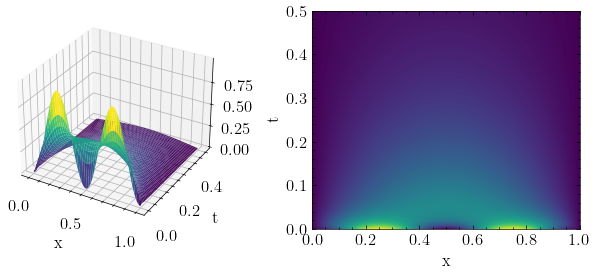

In [4]:
D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 1000, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

In [7]:
L, W = 2, 32
model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1)

N_I, N_LB, N_RB, N_D = 42, 12, 12, 1024
coef = 0.8
lr = 1e-3
num_iters = 5000
collect_every = 250

losses, errors = train(
    problem,
    model,
    N_LB, N_RB, N_I, N_D,
    coef=coef, lr=lr, num_iters=num_iters,
    collect_every=collect_every, print_every=2500
)

Iteration 0 --- Loss 0.2546723484992981 --- RMSE 0.19611105279706634
Iteration 2500 --- Loss 0.05143514275550842 --- RMSE 0.03883170860129607
Iteration 5000 --- Loss 0.01623900607228279 --- RMSE 0.026932073399917822


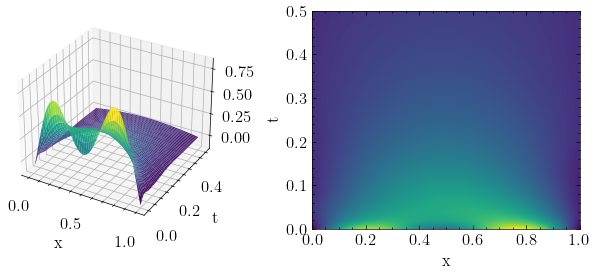

In [9]:
test_points = torch.cartesian_prod(problem.x, problem.t)
predictions = model(test_points).reshape(Nx, Nt).detach().numpy()
plot_pde(problem.x, problem.t, predictions.T, size=(6.5, 3))

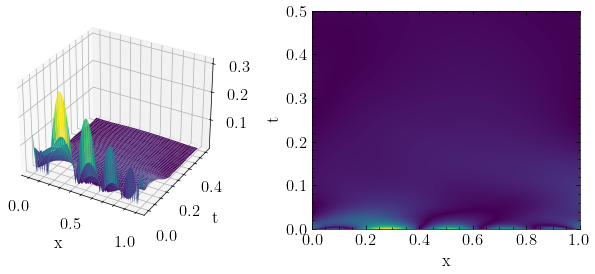

In [11]:
plot_pde(problem.x, problem.t, np.abs(predictions.T - problem.solution), size=(6.5, 3))

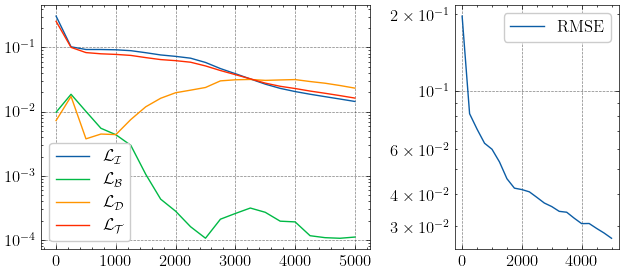

In [14]:
plt.style.use(['grid'])

plot_losses(
    np.arange(0, num_iters+1, collect_every),
    losses=[
        (losses[:,0], r'$\mathcal{L_I}$'),
        (losses[:,1], r'$\mathcal{L_B}$'),
        (losses[:,2], r'$\mathcal{L_D}$'),
        (losses[:,3], r'$\mathcal{L_T}$')
    ],
    errors=[
        (errors, r'RMSE'),
    ]
)